# Discussion - Support Vector Machines

In this example, we will be using [the Wine Dataset from UCI](https://archive.ics.uci.edu/ml/datasets/wine). <br >
The data is the results of a chemical analysis of wines grown in the same region in Italy. <br >
There are 13 different measurements taken from 3 types of wines.

We will use this dataset to build a linear Support Vector Machine. <br >

### Goals
- Support Vector Machines with Linear Kernel (Linear SVM)
- Hard Margin and Soft Margin
- Hinge Loss
- Extendning to Multi-class classification
- The impact of imbalance on SVM
- Non-linear SVM
- Primal and Dual form
- Kernel Trick in Non-linear SVM


Author: Yun-Hsin Kuo (2021 Fall TA)

2022 Fall: Dechen Gao (dcgao@ucdavis.edu)  
           Zhehao Tao (zhtao@ucdavis.edu)

In [1]:
# Install cvxpy for convex optimization
import sys
!{sys.executable} -m pip install cvxpy

You should consider upgrading via the 'c:\users\gerri\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


### Setup
SVM by default is bi-classification, so we are dropping the third class here.

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
# data contains a 2D array of shape (178, 13) with each row representing one sample and each column representing the features. 
# classes is an array of shape (178, 1) contains the target samples.
data, classes = load_wine(return_X_y=True, as_frame=True) 
data['class'] = classes
df = data.copy()
# This is like one vs. one
df = df.loc[(df['class'] != 2)]
df = df.replace({"class": {0: -1}})

df['class'].value_counts() 

 1    71
-1    59
Name: class, dtype: int64

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=21)

X_train, y_train = train.copy().drop(columns=['class']), train['class']
X_test, y_test = test.copy().drop(columns=['class']), test['class']
y_train.value_counts()

 1    61
-1    43
Name: class, dtype: int64

In [4]:
from IPython.display import Image
Image(url='https://miro.medium.com/max/1200/0*MgG8zoCB6CY4Fa19.gif')

## Linear Support Vector Machine

### Overview from a High Level
The main objective of SVM is to find an optimal hyperplane ( decision boundary ) that **distinctly and linearly separates two groups** of points. <br >
Ideally, all members of one group should fall on one side of the hyperplane. The other group should all fall on the other side. <br >

How should we define which hyperplane to be optimal? <br >
We would like each group stays away from the hyperplane as much as possible. The farther, the better. <br >

In [5]:
Image(url='https://miro.medium.com/max/1400/1*X_AJKt7EaQ9sO9j0e9IlGg.png', width=600)

Specifically, we would like that **the margin to be maximized**, where the margin is decided by some points from each class that are closest to the hyperplane. <br >
These "some points" are known as **support vectors**. <br >
Why maximized? To get higher confidence when classifying points. <br >
Typically, SVM is used to solve **binary classification** problem. <br >

Points fall above the boundary are annotated with label $y = +1$. <br >
On the other hand, those fall below the boundary are annotated with label $y = -1$. <br >
(But **you don't have to worry about labelling "correctly" when using the SVM on sklearn**.)

In [6]:
# Note that this picture has the oppotsite sign because of the direction of w.
Image(url='https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/494px-SVM_margin.png')

### Formulation

**Basic Look of the Hyperplane**

$f(x) = w^{T}x + b$

**Distinctly separate two groups of points**

$w^{T}x_i + b \geq 1, \forall y_i = +1$

$w^{T}x_i + b \leq -1, \forall y_i = -1$

For convenience, in this notebook, $x_i$ always refers to the $i^{\text{th}}$ **instance** in the training data of size $N$, so every $x_i$ itself is a vector of $M$ attributes.

By multiplying our label, we can combine these two ( dashed hyperplane ) to summarize our optimal decision boundary:

$y_{i}(w^{T}x_i + b) \geq 1$

Why we are picking 1 not 2? Because the weights can be scaled as well. <br > 

In [7]:
Image(url='https://miro.medium.com/max/1288/1*RdSqcpreH0fEfXoT2Njj9Q.png')

**Maximizing the margin**

It is the same as maximizing the [projected distance](https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_plane),

$\text{maximize} \dfrac{2}{||w||}$

which is **minimizing our coefficients: $\text{minimize} \dfrac{||w||}{2}$, or $\dfrac{||w||^2}{2}$**

Note that $||w||^2$ is squared sum of our coefficients, where another same expression is $w^T w$. <br >

If we have $m$ attributes, $||w|| = \sqrt{w_1^2 + w_2^2 + \ldots + w_m^2}$

For convenience, $w$ is always a **vector** of coefficients, i.e., $w = \{w_1, w_2, \ldots, w_m \}$ , throughout this notebook, we just skip the notation for $M$ attributes. <br >

---

We can put these two together to get a optimization problem defined as follow:

$$
\begin{array}{llll}
\text{min}  & \displaystyle \dfrac{1}{2} {||w||}^2 & \\
\text{s.t.}& \displaystyle y_{i}(w^{T}x_i + b) \geq 1 & \forall i \in \{1, \ldots, N\}\\
\end{array}
$$

Formally, this is a quadratic programming problem in its **primal** form for a **Hard-margin SVM**.

We can use some convex optimization library to solve this problem, such as [cvxpy](https://www.cvxpy.org/) or [cvxopt](https://cvxopt.org/)

In [8]:
import numpy as np
import cvxpy as cp

class LinearSVM:
    def __init__(self, soft=False, C=1):
        self.relax = soft
        self.C = C
        self.M = None # number of features/dimensions
        self.N = None # number of training data points
        
        self.X = None # features
        self.y = None # types
        
        self.w = None
        self.b = None
        self.e = None
        
    def fit(self, X, y):
        (self.N, self.M) = X.shape
        self.X = np.asarray(X)
        self.y = np.asarray(y).reshape(-1, 1)
        
        w = cp.Variable((self.M, 1)) # create variables with shape (M, 1)
        b = cp.Variable() # create single variable
        e = cp.Variable((self.N, 1)) # create variables with shape (N, 1)
        
        if self.relax: # Soft-margin SVM
            objective = cp.Minimize(cp.sum(cp.square(w)) * 0.5 + cp.sum(e) * self.C)
            constraints = [cp.multiply(self.y, (self.X @ w + b)) >= 1 - e, e >=0]
        else: # Hard-margin SVM
            objective = cp.Minimize(cp.sum(cp.square(w)) * 0.5)
            constraints = [cp.multiply(self.y, (self.X @ w + b)) >= 1]
            
        prob = cp.Problem(objective, constraints)
        
        prob.solve()
        self.w = w.value
        self.b = b.value
        self.e = e.value
        print(f'Status: {prob.status}')
        print(f'w values: {self.w}')
        print(f"Objective Value: {prob.value}")
        
    def predict(self, X):
        return np.sign((np.asarray(X) @ self.w + self.b))
        
    def getSupportVec(self):
        if self.relax: # Soft-margin SVM
            return (self.y * (self.X @ self.w + self.b) - 1 + self.e <= 1e-10)
        else: # Hard-margin SVM
            return (self.y * (self.X @ self.w + self.b) - 1 <= 1e-10)
        
    def getParams(self):
        return self.w

In [9]:
from sklearn.metrics import classification_report
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
print(scaler.transform(X_train))
svm = LinearSVM()
svm.fit(scaler.transform(X_train), y_train)

# Printing out support vectors
display(train.loc[svm.getSupportVec(), :])

print(classification_report(y_test, svm.predict(scaler.transform(X_test))))

[[-1.41186196 -0.2907371   0.95172812 ...  1.94038404  0.53225443
  -0.57581732]
 [ 0.76016608 -0.21460619  0.43771462 ... -0.46320101  0.15166608
   0.97732377]
 [ 0.76016608 -0.23998316 -0.04417304 ... -0.65295772  0.89169898
   0.07271651]
 ...
 [ 1.3742473   0.15335985  0.24495956 ...  0.10606914 -0.44036024
   0.81031936]
 [ 0.39626609  0.87660346  1.75487421 ... -0.08368758 -0.05977189
  -0.09428791]
 [ 1.51070979 -0.25267165 -0.07629888 ... -0.71620996  0.7436924
   0.55981273]]
Status: optimal
w values: [[-0.98545562]
 [-0.17253095]
 [-0.59093486]
 [ 0.55776521]
 [-0.06224845]
 [ 0.02113799]
 [ 0.14153272]
 [-0.08620351]
 [-0.14600079]
 [-0.43231056]
 [ 0.29656742]
 [-0.56567093]
 [-0.8647221 ]]
Objective Value: 1.5284343930564752


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
27,13.30,1.72,2.14,17.0,94.0,2.40,2.19,0.27,1.35,3.95,1.02,2.77,1285.0,-1
68,13.34,0.94,2.36,17.0,110.0,2.53,1.30,0.55,0.42,3.17,1.02,1.93,750.0,1
81,12.72,1.81,2.20,18.8,86.0,2.20,2.53,0.26,1.77,3.90,1.16,3.14,714.0,1
43,13.24,3.98,2.29,17.5,103.0,2.64,2.63,0.32,1.66,4.36,0.82,3.00,680.0,-1
95,12.47,1.52,2.20,19.0,162.0,2.50,2.27,0.32,3.28,2.60,1.16,2.63,937.0,1
73,12.99,1.67,2.60,30.0,139.0,3.30,2.89,0.21,1.96,3.35,1.31,3.50,985.0,1
25,13.05,2.05,3.22,25.0,124.0,2.63,2.68,0.47,1.92,3.58,1.13,3.20,830.0,-1
124,11.87,4.31,2.39,21.0,82.0,2.86,3.03,0.21,2.91,2.80,0.75,3.64,380.0,1
121,11.56,2.05,3.23,28.5,119.0,3.18,5.08,0.47,1.87,6.00,0.93,3.69,465.0,1
44,13.05,1.77,2.10,17.0,107.0,3.00,3.00,0.28,2.03,5.04,0.88,3.35,885.0,-1


              precision    recall  f1-score   support

          -1       1.00      0.94      0.97        16
           1       0.91      1.00      0.95        10

    accuracy                           0.96        26
   macro avg       0.95      0.97      0.96        26
weighted avg       0.97      0.96      0.96        26



In [10]:
pd.DataFrame(svm.getParams().reshape(1, -1), columns=X_train.columns)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-0.985456,-0.172531,-0.590935,0.557765,-0.062248,0.021138,0.141533,-0.086204,-0.146001,-0.432311,0.296567,-0.565671,-0.864722


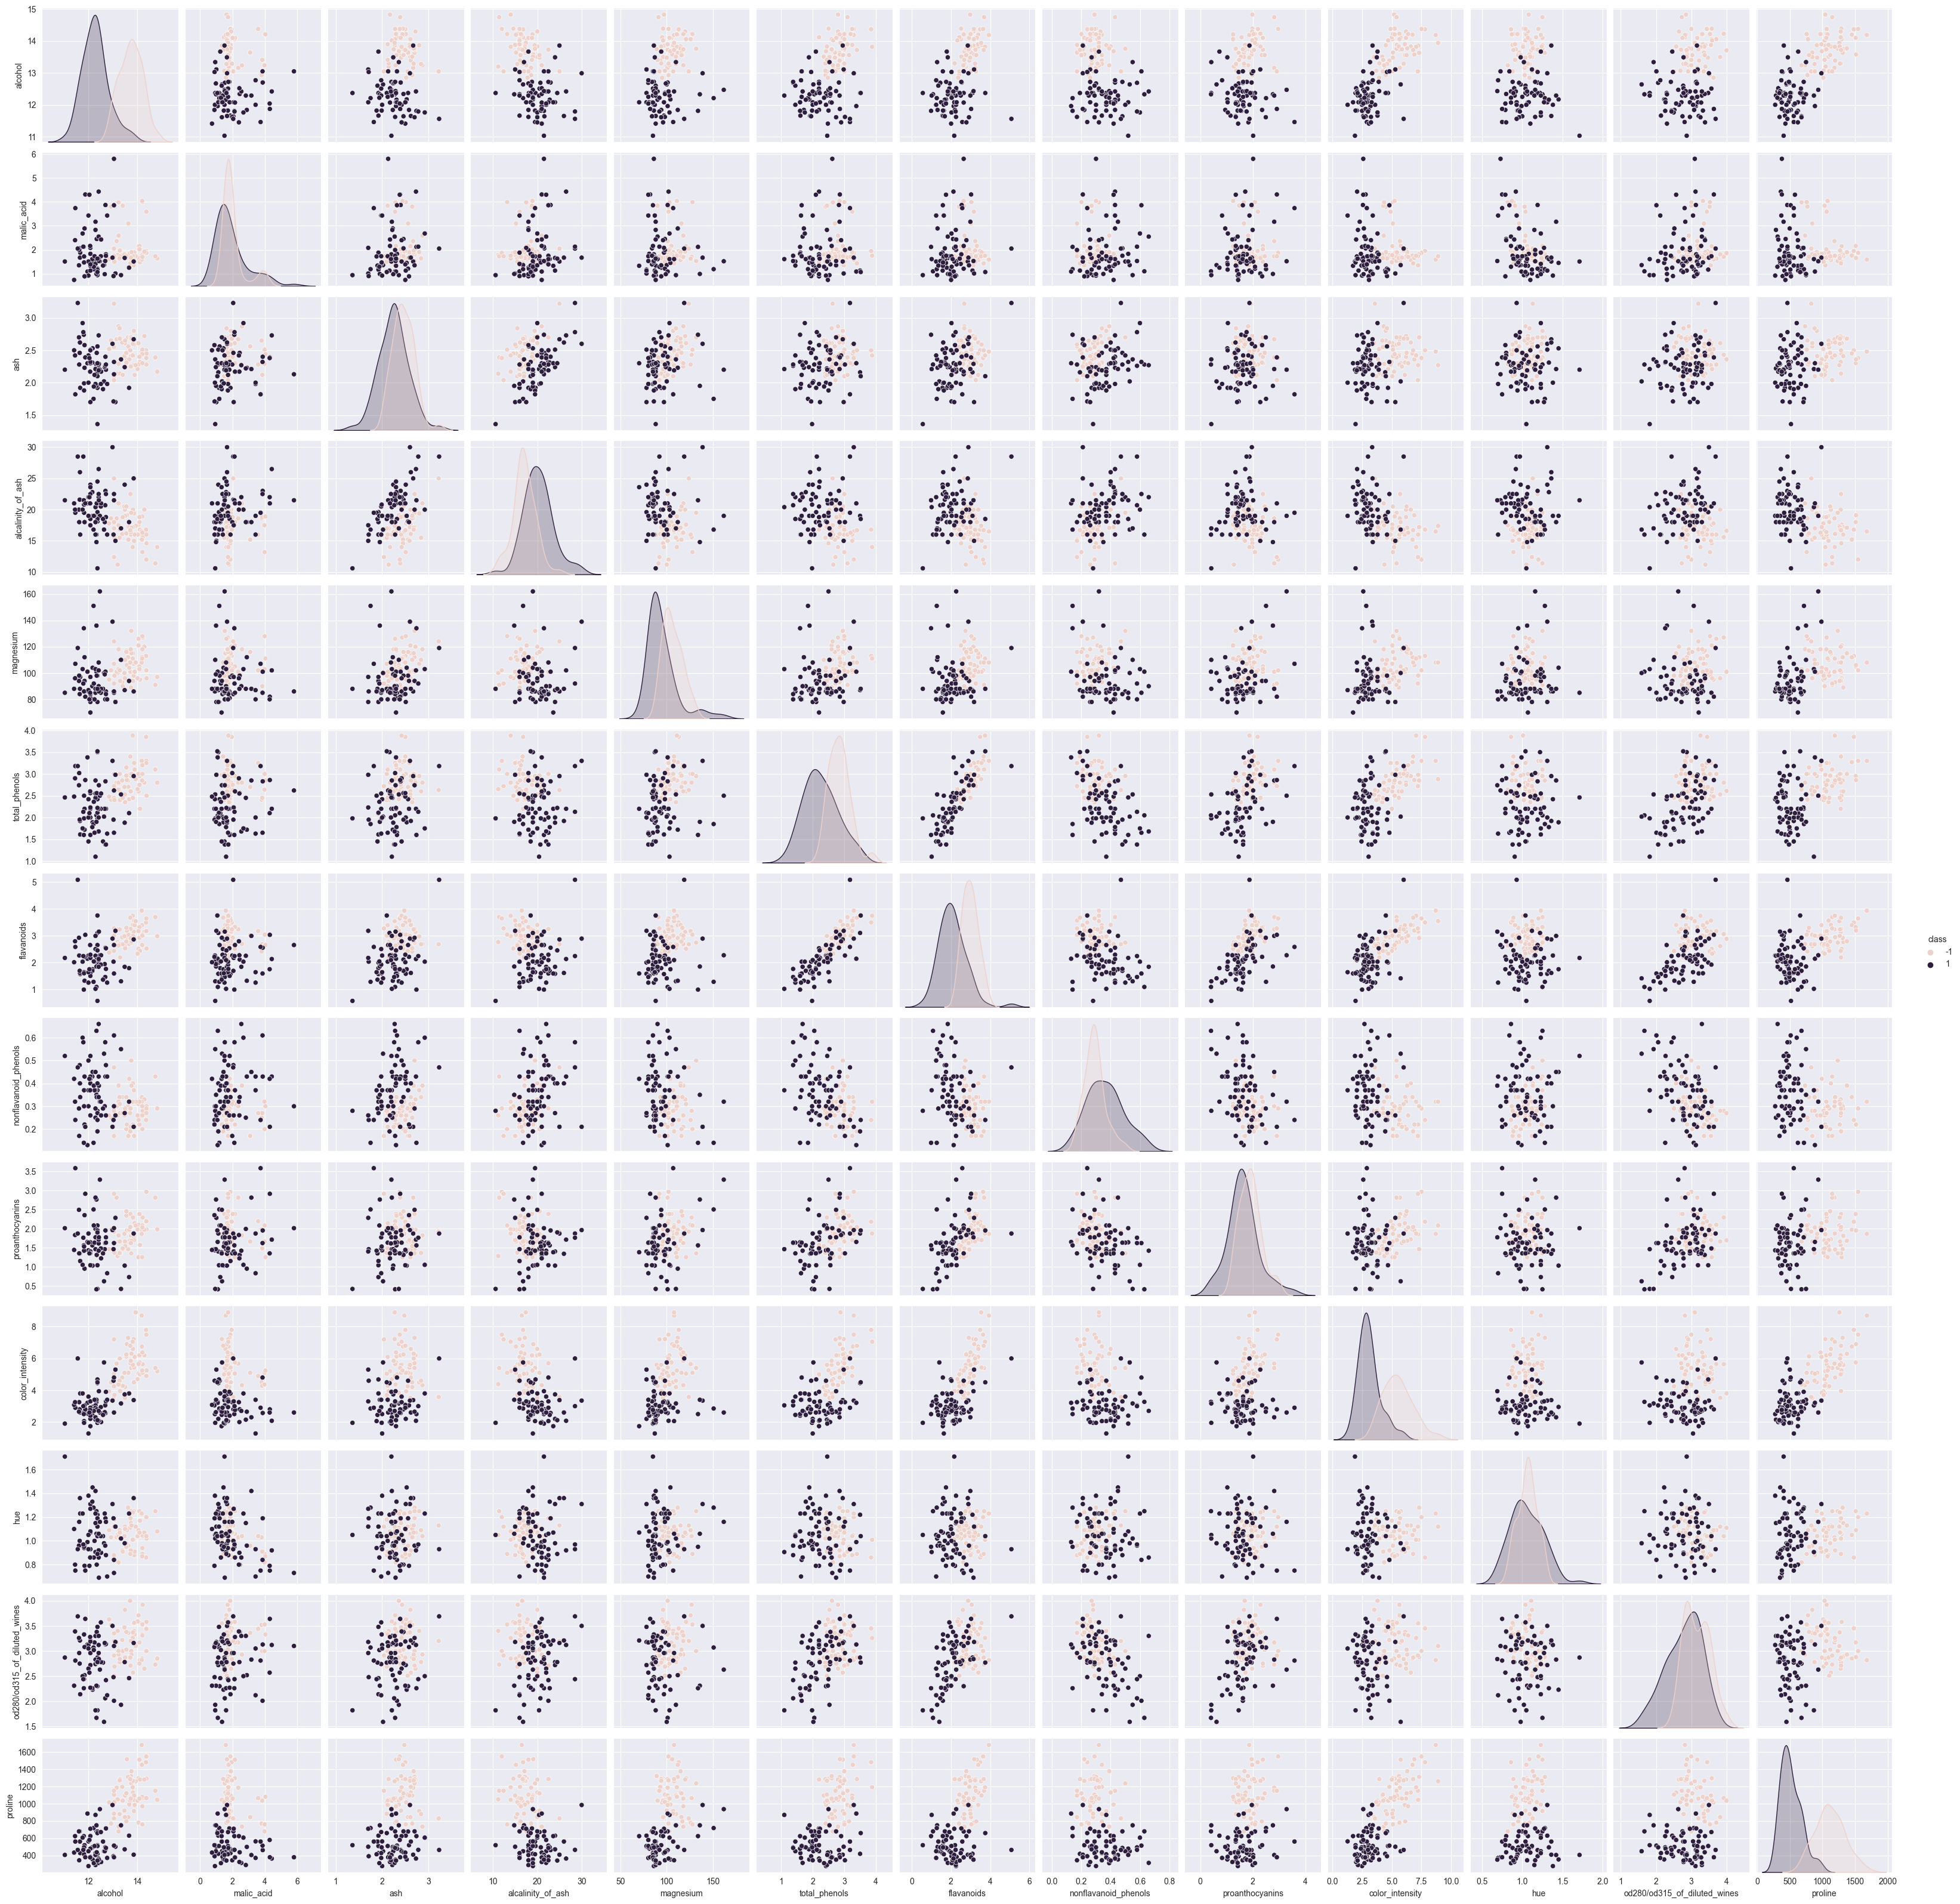

In [11]:
import seaborn as sns
sns.pairplot(df, hue='class')

### Sanity check on Hard-margin SVM
Generally, the difference between **LinearSVC()** and **SVC(kernel='linear')** is <br >
(1) the libraries used for implementation: liblinear and libsvm, and (2) the problem formulation. <br >
Because of the implementaion libraries, LinearSVC() handles scalability better. <br >
[Wiki](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

In [12]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report

scaler = preprocessing.StandardScaler()

clf = SVC(kernel='linear')
clf_li = LinearSVC(dual=False)

scaler.fit(X_train)
clf.fit(scaler.transform(X_train), np.asarray(y_train))
clf_li.fit(scaler.transform(X_train), np.asarray(y_train))

print('##### SVC with linear kernel #####')
print(classification_report(y_test, clf.predict(scaler.transform(X_test))), '\n')
print('##### Linear SVC #####')
print(classification_report(y_test, clf_li.predict(scaler.transform(X_test))), '\n')

##### SVC with linear kernel #####
              precision    recall  f1-score   support

          -1       1.00      0.94      0.97        16
           1       0.91      1.00      0.95        10

    accuracy                           0.96        26
   macro avg       0.95      0.97      0.96        26
weighted avg       0.97      0.96      0.96        26
 

##### Linear SVC #####
              precision    recall  f1-score   support

          -1       1.00      0.94      0.97        16
           1       0.91      1.00      0.95        10

    accuracy                           0.96        26
   macro avg       0.95      0.97      0.96        26
weighted avg       0.97      0.96      0.96        26
 



In [13]:
Image(url='https://miro.medium.com/max/1400/1*oeGKRVD-lp8x_2LkMuBBRg.png', width=500)

### Soft-margin SVM

Often we just cannot separate the two groups perfectly. <br >
So we should allow some **violations**, i.e., relax the margins, by adding slack variables, $\xi$ (ksi). <br >

\begin{array}{llll}
\text{min}  & \displaystyle \dfrac{1}{2} {||w||}^2 + C \cdot \sum_{i}^{N} \xi_i& \\
\text{s.t.}& \displaystyle y_{i}(w^{T}x_i + b) \geq 1 - \xi_i & \forall i\\
  & \displaystyle \xi_i \geq 0 & \forall i\\
\end{array}

Think of the violation to be $\xi_i = 1 - y_{i}(w^{T}x_i + b)$, and equivalently, $y_{i}(w^{T}x_i + b) = 1 - \xi_i$ means the remaining margin.

When $ 0 \leq \xi_i \leq 1$, it means instance $x_i$ **stays within the margin**, but $\xi_i \geq 1$ implies that instance $x_i$ is **misclassified**. <br >

$C$ is a hyperparameter that lets you decide how much you'd like to avoid misclassification. <br >
Small value of $C$ leads to more misclassified points because in this way, we allow these $\xi$ to have larger values. <br >
In lecture, $C$ is also referred to be a regularization parameter, a smaller value implies (1) we'd like to emphasize the regularization more, (2) a more of hard-margin classifier.<br >

On a side note, this is the implementaion used in **SVC** on [sklearn](https://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation). <br >

In [14]:
# Illustration of soft-margin SVM about noises and misclassification
Image(url='https://miro.medium.com/max/1400/1*ad-I0AE7rhBN26NOwYi3BA.jpeg', width=500)

In [15]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
svm = LinearSVM(soft=True, C=10)
svm.fit(scaler.transform(X_train), y_train)

#display(train.loc[svm.getSupportVec(), :])

print(classification_report(y_test, svm.predict(scaler.transform(X_test))))

Status: optimal
w values: [[-0.98545562]
 [-0.17253095]
 [-0.59093486]
 [ 0.55776521]
 [-0.06224845]
 [ 0.02113799]
 [ 0.14153272]
 [-0.08620351]
 [-0.14600079]
 [-0.43231056]
 [ 0.29656742]
 [-0.56567093]
 [-0.8647221 ]]
Objective Value: 1.5284343930564752
              precision    recall  f1-score   support

          -1       1.00      0.94      0.97        16
           1       0.91      1.00      0.95        10

    accuracy                           0.96        26
   macro avg       0.95      0.97      0.96        26
weighted avg       0.97      0.96      0.96        26



### Hinge Loss

The constraints do not really constrain any points when they are very far away from the hyperplane, i.e., when the points are not support vectors. <br >
In other words, only the constraints of the support vectors will have an actual influence on the problem solving. <br >
We can rewrite our penalty in this way, 

$\begin{equation}
       \text{Hinge} = 
        \begin{cases}
            0 & \text{if } y \cdot (w^{T}x + b) \geq 1 \\
            1 - y \cdot (w^{T}x + b) & \text{else}
        \end{cases}
\end{equation}$

We only calculates the loss when the points are not clearly classified onto the correct side.

Or,

$\text{Hinge} = \max(0, 1 - y \cdot (w^{T}x + b))$

Now we remove the slack variables and **be free of any constraints**, the problem of our Soft-margin now becomes:

$\text{minimize } \displaystyle {||w||}^2 + C \cdot \sum_{i=1}^N \max \left( 0,(1 - y_i \cdot (w^{T}x_i + b))\right)$

We can use gradient descents to update the coefficients. <br >
You can find the gradients in lecture videos. Or see the [cvxpy implementation](https://www.cvxpy.org/examples/machine_learning/svm.html) here. <br >
On the other hand, this is the implementation in **LinearSVC** on [sklearn](https://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation).


### Takeaway of Linear SVM covered above
 - Can only do binary classification
 - SVM tries to maximize the margin by minimizing the model coefficients, so that we can have higher confidence when doing the classficiation.
 - Unlike hard-margin, soft-margin allows some points to stay within the margin or even mis-classified.
 - Assumes the data is **linearly separable** in the original dimensional space
 
In other words, based on what we've covered so far, right now we cannot handle any non-linear datasets.

We mentioned a term "primal" eariler for our optimization problem. <br >
Generally, we can view the optimization problem from two perspectives, one is primal form, another is **dual form**. <br >
Unlike the primal form, the **dual** form allows us to do the **kernel trick**, and we are thus able to classify non-linear dataset.

### Multi-class SVM
SVM is only solves binary classification. To extend to multiple classes, there are two approaches. <br >
Say if we have $k$ classes, 

 - One-vs-all: The default on scikit-learn. Building $k$ SVMs.
     - Class 0 vs. \[Class 1, Class 2\]
     - Class 1 vs. \[Class 0, Class 2\]
     - Class 2 vs. \[Class 0, Class 1\]
 - One-vs-one: Building ${k \choose 2} = \dfrac{k(k-1)}{2}$ SVMs.
     - Class 0 vs. Class 1
     - Class 0 vs. Class 2
     - Class 1 vs. Class 2

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=21)

X_train, y_train = train.copy().drop(columns=['class']), train['class']
X_test, y_test = test.copy().drop(columns=['class']), test['class']
y_train.value_counts()

1    61
0    44
2    37
Name: class, dtype: int64

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

clf_ovo = SVC(kernel='linear') # The other is ovr

clf_ovo.fit(scaler.transform(X_train), np.asarray(y_train))

print(classification_report(y_test, clf_ovo.predict(scaler.transform(X_test))))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.90      0.95        10
           2       0.92      1.00      0.96        11

    accuracy                           0.97        36
   macro avg       0.97      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



### Impact of Imbalance on SVM and how SVM handles

The class weight will be applied to our hyperparameter $C$, such that the class assigned with a higher weight will have higher misclassification penalties. <br >
In other words, we prioritizes the minority class by making sure they are correctly classified as much as possible.

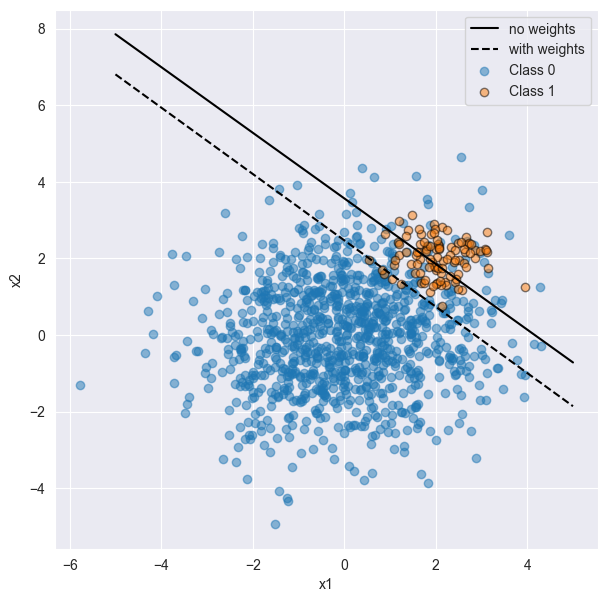

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.svm import SVC

# Create artificial dataset
N1 = 1000
N2 = 100
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(n_samples=[N1, N2], centers=centers, cluster_std=clusters_std, random_state=21, shuffle=False)

# Unweighted
clf = SVC(kernel='linear')
clf.fit(X, y)

x1 = np.linspace(-5, 5)

w1, w2 = clf.coef_.reshape(-1)
b = clf.intercept_.reshape(-1)
x2 = (-(w1)* x1 - b) / w2

# Weigthed
wclf = SVC(kernel='linear', class_weight={1: 10}) # Class 1 is our minority
wclf.fit(X, y)

w1, w2 = wclf.coef_.reshape(-1) 
b = clf.intercept_.reshape(-1)
x2_w = (-(w1)* x1 - b) / w2

#### plotting ####
plt.figure(figsize=(7, 7))
plt.plot(x1, x2, 'k-', label='no weights')
plt.plot(x1, x2_w, 'k--', label='with weights')
plt.scatter(X[(y == 0),0], X[(y == 0),1], c='tab:blue', alpha=.5, label='Class 0')
plt.scatter(X[(y == 1),0], X[(y == 1),1], c='tab:orange', alpha=.5, label='Class 1', edgecolors='k')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()

plt.show()

### Quick Review of Linear SVM

We talked about **Hard-margin SVM** in the **primal** form:

\begin{array}{llll}
\text{min}  & \displaystyle \dfrac{1}{2} {||w||}^2 & \\
\text{s.t.}& \displaystyle y_{i}(w^{T}x_i + b) \geq 1 & \forall i \in \{1, \ldots, N \}\\
\end{array}

and extended to the **Soft-margin SVM** in the **primal** form, which is the **SVC** implementaion on sklearn:

\begin{array}{llll}
\text{min}  & \displaystyle \dfrac{1}{2} {||w||}^2 + C \cdot \sum_{i}^{N} \xi_i& \\
\text{s.t.}& \displaystyle y_{i}(w^{T}x_i + b) \geq 1 - \xi_i & \forall i\\
  & \displaystyle \xi_i \geq 0 & \forall i\\
\end{array}

Alternatively, we can rewrite the **Soft-margin SVM** with **hinge loss**, which is the **LinearSVC** implementaion on sklearn:

$\text{minimize } \displaystyle \lambda{||w||}^2 + C \cdot \sum_{i=1}^N \max \left( 0,(1 - y_i \cdot (w^{T}x_i + b))\right)$

Note that this one is free of the constraints as we already incorporated them into the objective. <br >
In the following, we will go with the soft-margin SVM optimization formulation.

## Non-linear SVM

### High-level Idea
Our data points are not linearly separable in their original space. <br >But, maybe they are, if we project them into a **higher dimesional** space via a projection function, $\phi$. [Some example](https://towardsdatascience.com/svm-classifier-and-rbf-kernel-how-to-make-better-models-in-python-73bb4914af5b). <br >


Ideally, we could just replace all the data points, $X$, with the projected ones, $\phi(X)$, in SVM. <br >
Problem is, this leads to high computational complexity because we don't really know what projections make them linearly separable in the high dimensional space. <br >

But, ultimately, when things are linearly separable, one data point should be **similar to others in the same class** and be **dissimilar to others in a different class**. <br >
This implies that if we somehow can consider the relationships between instances in the problem formulation, then we could still utilize this higher dimensional space idea. <br >
**Spoiler:** By transforming the **primal** form of SVM into its **dual** form, we can consider instances' relationships.

### Background

This is our soft-margin SVM formulation in the **primal** form:

\begin{array}{llll}
\text{min}  & \displaystyle \dfrac{1}{2} {||w||}^2 + C \cdot \sum_{i}^{N} \xi_i& \\
\text{s.t.}& \displaystyle y_{i}(w^{T}x_i + b) \geq 1 - \xi_i & \forall i\\
  & \displaystyle \xi_i \geq 0 & \forall i\\
\end{array}

**Lagrange Multiplier** tries to incorporate constraints into the objective. It is a way solve to this optimization problem. <br >
When we are using the non-negative Lagrange Multiplier, we are also transforming this **primal** formulation into a **dual** formulation. <br >

### Duality of Optimization (optional)
In optimization theory, every optimization problem can be viewed from either of two perspectives. <br >
One is called the **primal** form, the other is called the **dual** form. <br >

When the **primal** refers to a minimization problem, the **dual** would then be a maximization problem. <br >
The **dual** provides a lower bound objective value to the problem we're trying to solve. <br > 
Just think of it as: the dual form provides the worst case feasible solution to us. <br >

Feel free to check out more details in [here](https://en.wikipedia.org/wiki/Duality_(optimization)).

### Transition from Primal to Dual (optional)
Here we only list what are the steps to take from a high level. We **skip some details** and logics because these are all about optimization, but you can find some of the details [here](https://medium.com/geekculture/the-optimization-behind-svm-primal-and-dual-form-5cca1b052f45). <br >

**Step 1**: In the primal form, for each unique constraint, we introduce different **non-negative** Lagrange Multipliers (LM), i.e., $\alpha$ and $\nu$, to each of the two unique constraints.

\begin{array}{llll}
\text{min}  & \displaystyle \dfrac{1}{2} {||w||}^2 + C \cdot \sum_{i}^N \xi_i& \\
\text{s.t.}& \displaystyle \color{red}{\alpha_i \big[}  y_{i}(w^{T}x_i + b) \geq 1 - \xi_i \color{red}{\big]} & \forall i\\
  & \displaystyle \color{red}{\nu_i \big[}\xi_i \geq 0 \color{red}{\big]} & \forall i \\
\end{array}

**Step 2**: Create a new objective that is, **the old subjective - the summation of contraints weighted by LM**.

$\begin{align}
\mathcal{L} & = \displaystyle \dfrac{1}{2} {||w||}^2 + C \cdot \sum_{i}^N \xi_i \color{red}{- \sum_{i}^N \alpha_i  (y_{i}(w^{T}x_i + b) - 1 + \xi_i ) - \sum_{i}^N \nu_i \xi_i} & 
\end{align}$ 

**Step 3**: Partially differentiate $\mathcal{L}$ with respect to the original unknowns, i.e., $w$, $b$, and $\xi$.

$\begin{align}
\mathcal{L=} & \displaystyle \dfrac{1}{2} {||w||}^2 + C \cdot \sum_{i}^N \xi_i \color{red}{- \sum_{i}^N \alpha_i y_{i}(w^{T}x_i) - \sum_{i}^N \alpha_i y_{i} b + \sum_{i}^N \alpha_i (1 - \xi_i ) - \sum_{i}^N \nu_i \xi_i} & \\
\end{align}$ 

$\begin{align}
\dfrac{\partial \mathcal{L}}{\partial w} & \mathbf{=0} & =  && w + 0 - \displaystyle \sum_i \alpha_i y_{i}x_i  - 0 + 0 - 0 & \implies & w = \displaystyle \sum_i \alpha_i y_{i}x_i  \\
\dfrac{\partial \mathcal{L}}{\partial b} & \mathbf{=0} &  =  && 0 + 0 - 0 - \displaystyle \sum_i \alpha_i y_{i} + 0 - 0 & \implies & \displaystyle \sum_i \alpha_i y_{i} = 0 \\
\dfrac{\partial \mathcal{L}}{\partial \xi} & \mathbf{ =0} & =  && 0 + C - 0 - 0 - \displaystyle \sum_i \alpha_i - \displaystyle \sum_i \nu_i & \implies & \displaystyle C = \displaystyle \sum_i \alpha_i + \displaystyle \sum_i \nu_i \\
\end{align} $

**Step 4**: Now plug these three equations back to $\mathcal{L}$.

\begin{array}{llll}
\mathcal{L} & = & \displaystyle \dfrac{1}{2} {||w||}^2 + C \cdot \sum_{i}\xi_i \color{red}{- w^{T}w} - \sum_{i} \alpha_i y_{i} b + \sum_{i} \alpha_i - \sum_{i} \alpha_i \xi_i - \sum_{i}\nu_i \xi_i & \\
& = & \displaystyle \dfrac{1}{2} {||w||}^2 + C \cdot \sum_{i}\xi_i - {||w||}^2 \color{red}{- 0} + \sum_{i} \alpha_i - \sum_{i} \alpha_i \xi_i - \sum_{i}\nu_i \xi_i & \\
& = & \displaystyle \dfrac{1}{2} {||w||}^2 - {||w||}^2 + \sum_{i} \alpha_i + \color{red}{(\sum_{i} \alpha_i + \sum_{i} \nu_i)} \cdot \sum_{i}\xi_i  - \sum_{i} \alpha_i \xi_i - \sum_{i}\nu_i \xi_i \\
& = & \displaystyle \dfrac{-1}{2} {||w||}^2 + \sum_{i} \alpha_i \\
\end{array}

**Step 5**: Now replace $w$ with the alternative expression in $\mathcal{L}$, and we maximize this objective.

$w = \displaystyle \sum_i \alpha_i y_{i}x_i $

\begin{array}{llll}
\mathcal{L} & = & \displaystyle \dfrac{-1}{2} {||w||}^2 + \sum_{i} \alpha_i \\
& = & \displaystyle \sum_{i} \alpha_i - \dfrac{1}{2} \cdot \sum_i \sum_j \alpha_i \alpha_j y_i y_j (x_i^T x_j)
\end{array}

Now in the dual form of SVM , our only unknown is $\alpha$, which is non-negative.

### Dual form of SVM

\begin{array}{llll}
\text{maximize}  & \displaystyle \sum_{i}^N \alpha_i - \dfrac{1}{2} \cdot \sum_i \sum_j \alpha_i \alpha_j y_i y_j \color{red}{(x_i^T x_j)}& \\
\text{s.t.} & 0 \leq \alpha_i \leq C & \forall i \\
& \displaystyle \sum_i \alpha_i y_i = 0 & \forall i \\
\end{array}

As we spot the innerproduct of instances in the dual form, this allows us to apply the kernel trick here. <br >

## Kernel Trick

Kernels are **similarity functions** that consider the inner product of the pairs of data points, projected or not. <br >
Choosing a kernel $K$ is the same as choosing the projection function, $\phi$. Because using the kernel trick, we never explicitly define what is $\phi$.

$K(x_i, x_j) = \phi(x_i)^T \cdot \phi(x_j)$

The trick is that, we do not explicitly project the data points via $\phi$ and then compute their similarity. <br >
Instead, this sequential process can be densed into a more simplified formula that takes data points in the original space. <br >
In other words, think of it as: **by taking the original data points, the kernel tells you that, this is their similarity in the high-dimensional space.** <br >
This is how we reduce the computational complexity.


Since we have the inner product of the instances in the dual form, this is why we can apply the kernel trick.

## Non-linear SVM Formulation

\begin{array}{llll}
\text{maximize}  & \displaystyle \sum_{i}^N \alpha_i - \dfrac{1}{2} \cdot \sum_i \sum_j \alpha_i \alpha_j y_i y_j K(x_i, x_j)& \\
\text{s.t.} & 0 \leq \alpha_i \leq C & \forall i \\
& \displaystyle \sum_i \alpha_i y_i = 0 & \forall i \\
\end{array}

The hyperplane with the maximum margin: $\displaystyle \sum_i \alpha_i y_i x_i \cdot x + b \geq 0$, where $x$ is the input instance.

### Intuition behind $\alpha$ (optional)

Back in the linear SVM, we mention that only support vectors would actually constrain the optimization problem. (specifically, the hinge loss section) <br >
So this idea will be reflected on the values of $\alpha_i$ as we were doing $\displaystyle \color{red}{\alpha_i \big[}  y_{i}(w^{T}x_i + b) \geq 1 - \xi_i \color{red}{\big]}, \forall i$ when doing the dual form. <br >

All the takeaway here is that, $\alpha$ will be **nonzero** for those instances being support vectors. Otherwise, $\alpha$ is zero. <br >
This also reflects the idea that only support vectors decide what the hyperplane looks like.


### Popular Kernels

- Linear: $K_L(x_i, x_j) = x_i^T \cdot x_j$ (In other words, $\phi$ is the identity function)
- Polynomial : $K_P(x_i, x_j) = (r + \gamma (x_i^T \cdot x_j))^p$, where $p$ is the polynomial degree, $r$ is an independent constant, and $\gamma$.
- Radial Basis Function (RBF) : RBF kernel is a very generalized kernel function due to its similarity to **Gaussian distribution**. It is defined as $K_{RBF}(x_i, x_j) = \exp{(\gamma ||x_i - x_j||^2)}$, where $||x_i — x_j||$ is the Euclidean distance between $x_i$ and $x_j$. Check out more details in [here](https://towardsdatascience.com/radial-basis-function-rbf-kernel-the-go-to-kernel-acf0d22c798a) and [here](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html).
- Sigmoid: $K_S(x_i, x_j) = \tanh{(r + \gamma \cdot (x_i^T \cdot x_j))}$, sigmoid and tanh are a bit different when it comes to optimization, but they look similar.

Essentially, we still don't know what would be the projection that makes things linearly separable, so the kernels (along with others like $\gamma$) are just another hyperparameter for tuning. <br >
More comprehensive review on [here for kernels](https://scikit-learn.org/stable/modules/metrics.html#linear-kernel) or [here for kernels only related to SVM](https://scikit-learn.org/stable/modules/svm.html#kernel-functions). <br >
Finally, very quick [visual comparison](https://scikit-learn.org/stable/modules/svm.html#classification) between different kernels on another dataset.

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

# Try to play with the hyperparameters and break the model :)
# clf_non = SVC(kernel='sigmoid', gamma=1.0, coef0 = 1) # gamma, r.
clf_non = SVC(kernel='poly', degree=3, gamma=1.0, coef0 = 1) # p, gamma, r.
# clf_non = SVC(kernel='rbf', gamma=1.0) # gamma

clf_non.fit(scaler.transform(X_train), np.asarray(y_train))

print(classification_report(y_test, clf_non.predict(scaler.transform(X_test))))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.90      0.95        10
           2       1.00      1.00      1.00        11

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



### Takeaway of Non-linear SVM
 - Assumes the data is linearly separable in the **high dimensional space**
 - It considers the **dual** form of the linear SVM formulation
 - This dual form considers the inner product of instances, which allows us to apply the **kernel trick**, and we are thus able to handle the **non-linear** dataset.
 - Kernels are hyperparameters, no correct or wrong to pick which.
 - We don't always prefer non-linear SVM over linear SVM, because it is not that intuitive in terms of the interpretation.
 
 
[**Playground for different kernels**](https://dash.gallery/dash-svm/)